In [1]:
# making the cramer rao lower bound plots
# essentially, how well you can constrain the position of something is given by how much its gradient changes
# first, we need to generate airy disc and toliman psfs. 

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird. sike using jax
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr
import jax.numpy as jnp

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number, prevent aliasing
wf_npixels = 1024

# for this one, make 512*512
psf_npixels = 128

# no need for oversampling
oversample = 1 # can change, put to 1 for normal toliman

# toliman pixel scale (arc seconds)
psf_pixel_scale = 0.375

# just for future use:
det_pixelsize = dlu.arcsec2rad(psf_pixel_scale/oversample)

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

In [28]:
idx = 5

In [29]:
# gonna try 10 sources close(r) together... 50 takes way too long... prone to breaking on my silly macbook.
n_sources = 10

# good maximum for 512 by 512 grid
max_pos = 20/oversample
positions_arcsecs = jr.uniform(jr.PRNGKey(idx), (n_sources, 2), minval=-max_pos, maxval=max_pos)
positions_rads = dlu.arcsec2rad(positions_arcsecs)

# fluxes from half-normal distribution, standard deviation 50,000 photons
fluxes = 50000*jnp.abs(jr.normal(jr.PRNGKey(idx), (n_sources,)))

# only 1 wavelength
wavelength = 585e-9 #mid(ish) point of toliman thing
wavelengths = wavelength * jnp.linspace(1, 1, 1)

sources = dl.PointSources(wavelengths,positions_rads,fluxes)

In [30]:
# modelling johson noise
# NOte: OVERSAMPLE SHOULD BE 1... unless.... we want 200% better pixel scale!!!
def bg_noise(dark_current, key): 
    noise_vals = (jnp.pi/2)**0.5*dark_current*jnp.abs(jr.normal(key, (psf_npixels*oversample,psf_npixels*oversample)))
    return noise_vals

# there is a 'addconstant' detector layer. but not sure how I can go from that to what I want.
# I think I just use it for modelling the mean value of detector noise.

In [31]:
# adding the constant to model dark current... not working too well!
detector = dl.LayeredDetector([dl.layers.AddConstant(0)])

tolTelescope = dl.Telescope(tolPupilSystem, sources, detector)
airyTelescope = dl.Telescope(airyApertureSystem, sources, detector)

init_dark_current = 2
# no poisson
tolData = tolTelescope.model() + bg_noise(init_dark_current, jr.PRNGKey(idx))

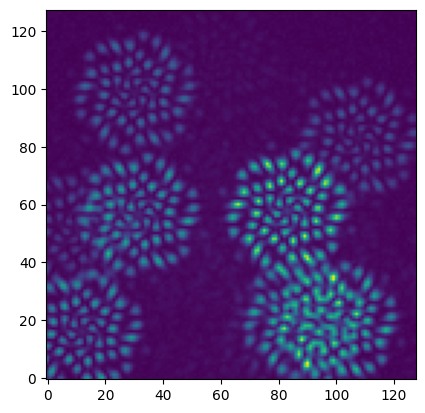

In [33]:
plt.imshow(tolData, origin='lower')
plt.show()

In [103]:
model_positions = 'source.position'
model_fluxes = 'source.flux'

# don't know about this one
model_dark_current = 'detector.AddConstant.value'

# params
parameters = [model_positions, model_fluxes, model_dark_current]

In [104]:
# just gonna do toliman for now
# plus/mins 0.5 pixels in each dimension. gonna assume uniform distribution because nothing mentioned

tolModel = tolTelescope.add(model_positions, jr.uniform(jr.PRNGKey(0),(n_sources, 2),minval=-0.5*det_pixelsize,maxval=0.5*det_pixelsize))

# fluxes +/- 10%
tolModel = tolModel.multiply(model_fluxes, jr.uniform(jr.PRNGKey(0), (n_sources,), minval=0.9, maxval=1.1))

# dark current +/-20%
tolModel = tolModel.add(model_dark_current, init_dark_current*jr.uniform(jr.PRNGKey(0),1,minval=0.8,maxval=1.2))

In [105]:
# importing optax stuff
# Optimisation
import zodiax as zdx
import optax

# this stuff really depends on how many sources you have
pos_optimiser   = optax.adam(7e-9) # good value
flux_optimiser  = optax.adam(200) # good value
current_optimiser = optax.adam(0.02*0.2*init_dark_current)

optimisers = [pos_optimiser, flux_optimiser, current_optimiser]

optim, opt_state = zdx.get_optimiser(tolModel, parameters, optimisers)

In [106]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model()
    return jnp.sum((data-out)**2)

In [107]:
%%time
loss, grads = loss_fn(tolModel, tolData) # Compile
print("Initial Loss: {}".format(float(loss)))

Initial Loss: 1097127.625
CPU times: user 8.46 s, sys: 149 ms, total: 8.61 s
Wall time: 1.58 s


In [108]:
from tqdm.notebook import tqdm
# 5.988
# 17 works
# 18 works
# 19 doesn't

In [109]:
losses, models_out = [], []
with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(tolModel, tolData)    
        updates, opt_state = optim.update(grads, opt_state)
        tolModel = zdx.apply_updates(tolModel, updates)
        losses.append(loss)
        models_out.append(tolModel)
        t.set_description("Log Loss: {:.3f}".format(jnp.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [110]:
nepochs = len(models_out)
psfs_out = models_out[-1].model()

positions_found  = jnp.array([model.get(model_positions) for model in models_out])
fluxes_found     = jnp.array([model.get(model_fluxes)    for model in models_out])
current_found = jnp.array([model.get(model_dark_current) for model in models_out])

In [111]:
flux_residuals = fluxes - fluxes_found
current_residuals = init_dark_current - current_found

scaler = 1e3
positions_residuals = positions_rads - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
r_residuals = dlu.rad2arcsec(r_residuals_rads)

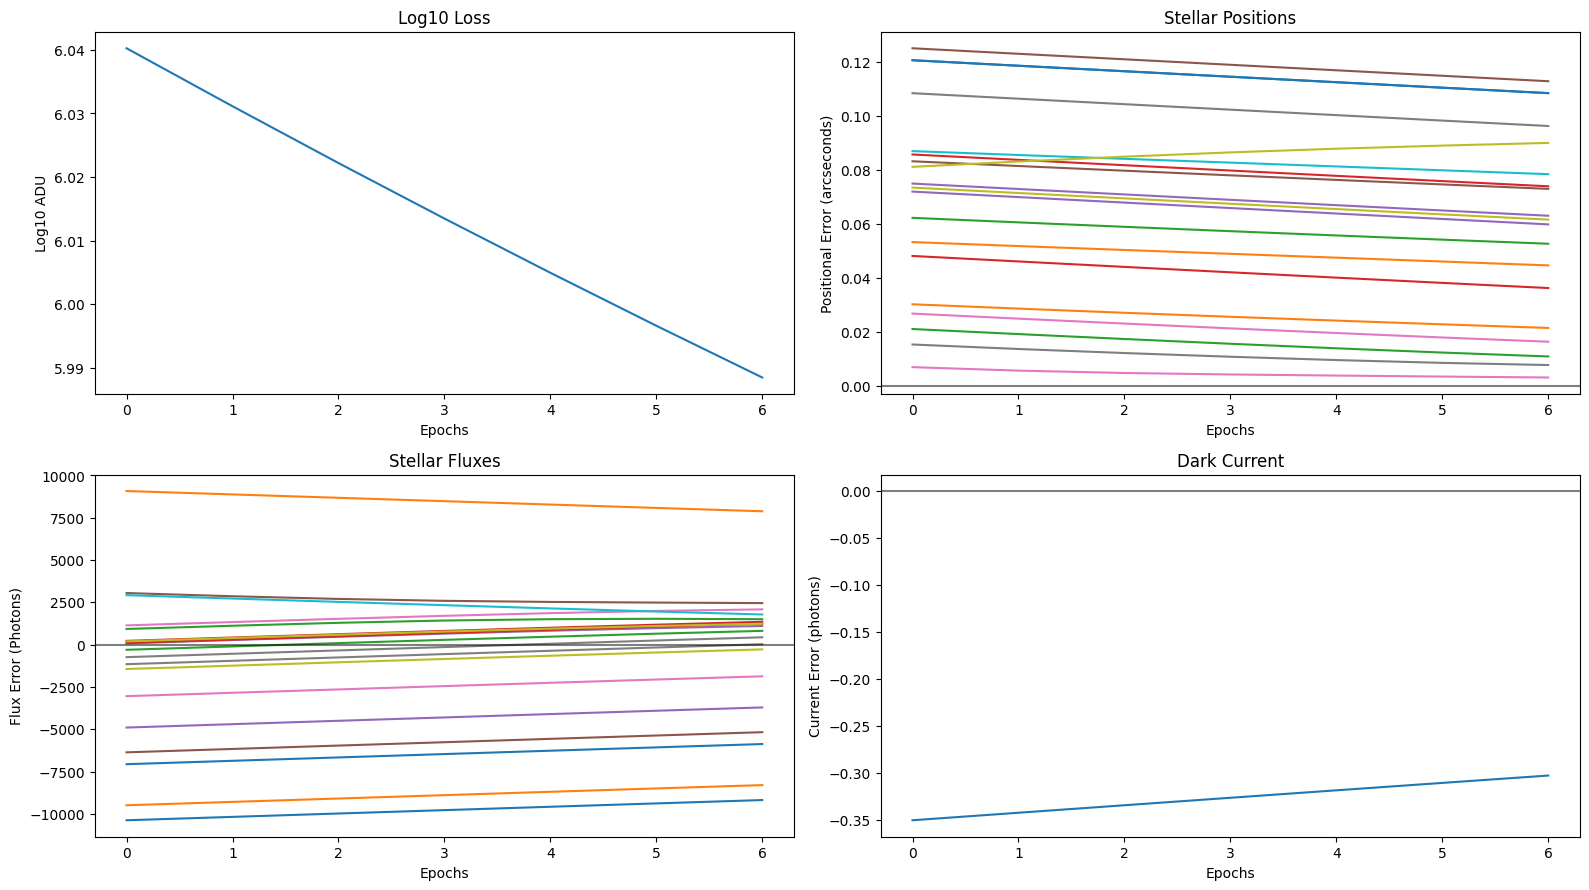

In [112]:
j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(np.array(losses)[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Dark Current")
plt.xlabel("Epochs")
plt.ylabel("Current Error (photons)")
plt.plot(current_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

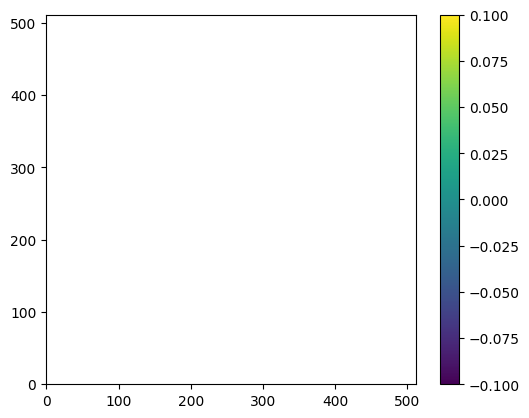

In [272]:
plt.imshow(psfs_out,origin='lower')
plt.colorbar()
plt.show()

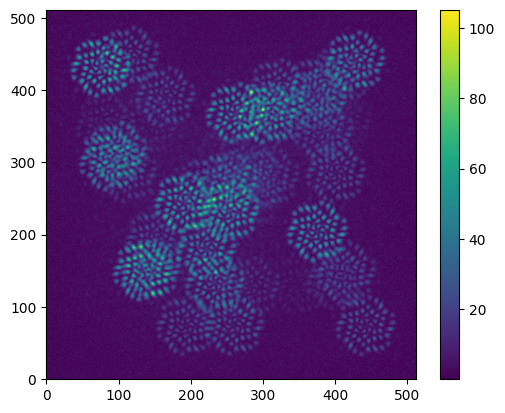

In [257]:
plt.imshow(tolData,origin='lower')
plt.colorbar()
plt.show()